In [19]:
from CBIR.models import ContrastiveExtractor
import matplotlib.pyplot as plt
from torchvision.datasets import CocoDetection
import numpy as np
from collections import Counter
from tqdm import tqdm
import torch
from sklearn.decomposition import PCA
import random

In [76]:
model = ContrastiveExtractor(input_size=224, embedding_size=256)
_ = model.load('/home/artem/dev/Content-Based-Image-Retrieval/Checkpoints/ContrastiveExtractor/checkpoint1')
_ = model.to('cuda')

In [20]:
coco_dataset = CocoDetection(root='/home/artem/data/COCO/train2017',
                             annFile='/home/artem/data/COCO/annotations/instances_train2017.json',
                             transform=np.array)

loading annotations into memory...
Done (t=6.17s)
creating index...
index created!


In [21]:
supercat_map = {}
cat_map = {}
for cat in coco_dataset.coco.getCatIds():
    supercat_map[cat] = coco_dataset.coco.loadCats([cat])[0]['supercategory']
    cat_map[cat]      = coco_dataset.coco.loadCats([cat])[0]['name']

supercat_to_id = {'background': 0}
id_to_supercat = {0: 'background'}
for i, supercat in enumerate(np.unique(list(supercat_map.values()))):
    supercat_to_id[supercat] = i + 1
    id_to_supercat[i + 1] = supercat

In [22]:
supercat_to_id

{'background': 0,
 'accessory': 1,
 'animal': 2,
 'appliance': 3,
 'electronic': 4,
 'food': 5,
 'furniture': 6,
 'indoor': 7,
 'kitchen': 8,
 'outdoor': 9,
 'person': 10,
 'sports': 11,
 'vehicle': 12}

In [25]:
from models import ResNet18withSobel

In [52]:
stage_1_model = ResNet18withSobel(128)
stage_1_model.to('cuda')
stage_1_model = torch.nn.DataParallel(stage_1_model, device_ids=range(torch.cuda.device_count()))
checkpoint = torch.load('/home/artem/dev/TwoStageUC/checkpoint/ckpt_embed.t7')
stage_1_model.load_state_dict(checkpoint['net'])

<All keys matched successfully>

In [88]:
tile_size = 32
n_tiles = 500
cat_items = {}

for target_cat in ['person', 'food', 'animal', 'accessory']:
    cat_items[target_cat] = []

    with tqdm(total=n_tiles) as pbar:
        for image, target in coco_dataset:
            if len(cat_items[target_cat]) >= n_tiles:
                break
            if target_cat in set(map(lambda x: supercat_map[x['category_id']], target)):
                mask = np.zeros(image.shape[:2])
                for elem in sorted(target, key=lambda x: -x['area']):
                    mask[np.where(coco_dataset.coco.annToMask(elem) == 1)] = supercat_to_id[supercat_map[elem['category_id']]]

                h, w = image.shape[:2]
                for x in range(0, w - tile_size, int(tile_size / 2)):
                    for y in range(0, h - tile_size, int(tile_size / 2)):
                        tile = mask[y:y + tile_size, x:x + tile_size]
                        tile_class = int(Counter(tile.ravel()).most_common(1)[0][0])
                        if id_to_supercat[tile_class] == target_cat:
                            cat_items[target_cat].append(image[y:y + tile_size, x:x + tile_size, :])
                            pbar.update(1)

stage_1_model.eval()
model.eval()

for cat in cat_items.keys():
    tiles = cat_items[cat]
    embeddings = []
    for tile in tqdm(tiles):
        # embeddings.append(np.array(stage_1_model(torch.moveaxis(torch.stack([torch.Tensor(tile)]), 3, 1).to('cuda')).detach().cpu())[0])
        embeddings.append(np.array(model.get_embedding(torch.moveaxis(torch.stack([torch.Tensor(tile)]), 3, 1).to('cuda'))[0].detach().cpu()))
    cat_items[cat] = embeddings
    
all_embeds = []
for embeds in cat_items.values():
    for embed in embeds:
        all_embeds.append(embed)

1367it [00:00, 2665.30it/s]                                                                                                                                                                                                            
530it [00:00, 3294.53it/s]                                                                                                                                                                                                             
651it [00:00, 3570.56it/s]                                                                                                                                                                                                             
521it [00:00, 2002.02it/s]                                                                                                                                                                                                             
100%|███████████████████████████████████████████████████████████████████

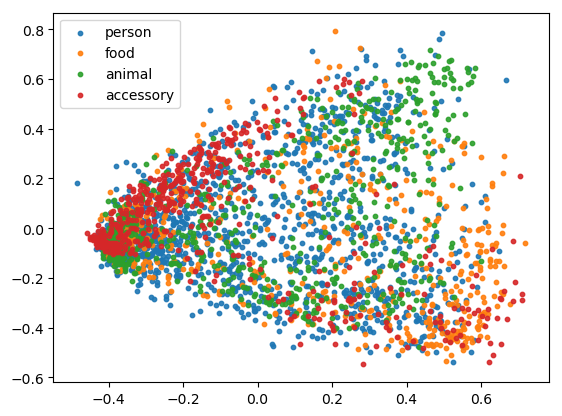

In [87]:
pca = PCA(n_components=2).fit(all_embeds)
for cat, embeds in cat_items.items():
    embeds = pca.transform(embeds)
    x = list(map(lambda x: x[0], embeds))
    y = list(map(lambda x: x[1], embeds))
    plt.scatter(x, y, label=cat, s=10, alpha=0.9)
    
plt.legend()
plt.show()

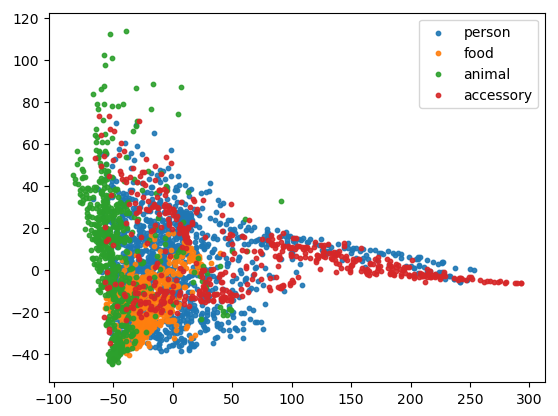

In [89]:
pca = PCA(n_components=2).fit(all_embeds)
for cat, embeds in cat_items.items():
    embeds = pca.transform(embeds)
    x = list(map(lambda x: x[0], embeds))
    y = list(map(lambda x: x[1], embeds))
    plt.scatter(x, y, label=cat, s=10, alpha=0.9)
    
plt.legend()
plt.show()

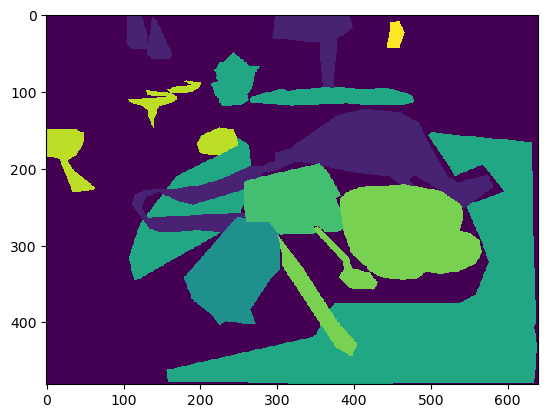

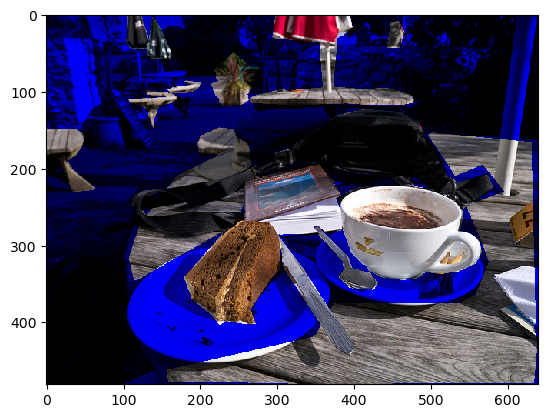

In [89]:
image, target = coco_dataset[23]

mask = np.zeros(image.shape[:2])
for elem in sorted(target, key=lambda x: -x['area']):
    x, y, w, h = map(int, elem['bbox'])
    mask[np.where(coco_dataset.coco.annToMask(elem) == 1)] = supercat_to_id[supercat_map[elem['category_id']]]
    
image[:, :, 0] *= (1 * (mask != 0)).astype('uint8')
image[:, :, 1] *= (1 * (mask != 0)).astype('uint8')
    
plt.imshow(mask)
plt.show()
plt.imshow(image)
plt.show()